In [2]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

In [3]:
#Functions that will be used for postprocessing
class apce_data_struct:
    def __init__(self, t, ds_t, icemass, h2omass, numparts):
        self.t = t
        self.ds_t = ds_t
        self.icemass = icemass
        self.h2omass = h2omass
        self.numparts = numparts
    
def read_apcemm_data(directory):
    t_mins = []
    ds_t = []
    ice_mass = []
    total_h2o_mass = []
    num_particles = []

    for file in sorted(os.listdir(directory)):
        if(file.startswith('ts_aerosol') and file.endswith('.nc')):
            file_path = os.path.join(directory,file)
            ds = xr.open_dataset(file_path, engine = "netcdf4", decode_times = False)
            ds_t.append(ds)
            tokens = file_path.split('.')
            mins = int(tokens[-2][-2:])
            hrs = int(tokens[-2][-4:-2])
            t_mins.append(hrs*60 + mins)

            ice_mass.append(ds["Ice Mass"])
            num_particles.append(ds["Number Ice Particles"])
            dx = abs(ds["x"][-1] - ds["x"][0])/len(ds["x"])
            dy = abs(ds["y"][-1] - ds["y"][0])/len(ds["y"])
            
            h2o_mass = np.sum(ds["H2O"]) * 1e6 / 6.022e23 * 0.018 * dx*dy + ds["Ice Mass"]
            total_h2o_mass.append(h2o_mass.values)
            
    return apce_data_struct(t_mins, ds_t, ice_mass, total_h2o_mass, num_particles)

def removeLow(arr, cutoff = 1e-3):
    func = lambda x: (x > cutoff) * x
    vfunc = np.vectorize(func)
    return vfunc(arr)

In [ ]:
def generate_indicies(ds_tt, samples):
    """Splits the domain based on the number of samples 
    and returns lists of IWCs, Eff_rads and xs."""

    indices = []
    values = []
    IWCs = []
    Eff_rads = []
    xs = []

    for i in range(0, samples):
        index = i * int(len(ds_tt['x'])/samples)
        indices.append(index)
        values.append(np.float32(ds_tt['x'][index].values))

    for i in range(0,len(indices)-1):
        IWCs.append(ds_tt['IWC'][:, indices[i]:indices[i+1]+1:1])
        Eff_rads.append(ds_tt['Effective radius'][:, indices[i]:indices[i+1]+1:1])
        xs.append(ds_tt["x"][indices[i]:indices[i+1]+1:1])

    ys = ds_tt["y"].values

    return IWCs, Eff_rads, xs, ys

def average_columns(IWCs, Eff_rads):
    """Averages the ice water content and effective radius
    along the columns and returns the averaged quantities"""

    IWCs_avg = []
    Eff_rads_avg = []

    for i in range(0, len(IWCs)):

        temp1 = []
        for j in IWCs[i]:
            temp1.append((j.values).mean())

        temp2 = []
        for j in Eff_rads[i]:
            temp2.append((j.values).mean())

        IWCs_avg.append(temp1)
        Eff_rads_avg.append(temp2)

    return IWCs_avg, Eff_rads_avg

def adjust_altitude(IWCs_avg, Eff_rads_avg, ys, base_altitude):

    ys = (ys + base_altitude)/1000
    ys = np.concatenate(([0, min(ys)-1/1000],ys))

    temp = [0,0]

    Eff_rads_temp_avg = []
    IWCs_temp_avg = []

    for i in range(0, len(Eff_rads_avg)):
        Eff_rads_temp_avg.append(np.concatenate((temp, Eff_rads_avg[i])) * 10 ** 6)
        IWCs_temp_avg.append(np.concatenate((temp, IWCs_avg[i]))*1000)


    IWCs_avg = IWCs_temp_avg
    Eff_rads_avg = Eff_rads_temp_avg

    return IWCs_avg, Eff_rads_avg, ys

def write_cloud_files(IWCs_avg, Eff_rads_avg, ys):

    try: 
        os.makedirs("clouds")
    except:
        pass

    for i in range(0,len(IWCs_avg)):

        file_name = (f"./clouds/cloud{i}.DAT")

        with open(file_name, "w") as f:
            f.write("#      z         IWC          R_eff\n")
            f.write("#     (km)     (g/m^3)         (um)\n")

            for j in range(len(ys)-1, 0, -1):
                if (Eff_rads_avg[i][j] < 9.49): 
                    Eff_rads_avg[i][j]=9.49
                elif (Eff_rads_avg[i][j] > 293.32):
                    Eff_rads_avg[i][j]=293.3

                f.write(f"     {ys[j]:.3f}   {IWCs_avg[i][j]:.9f}   {Eff_rads_avg[i][j]:.9f}\n")

def write_inp_files(atmosphere_file_path, solar_source_path, time, latitude, longitude, albedo, ice_habit, xs):

    solver = "disort"
    correlated_k = "fu"
    ice_parameterisation = "yang"

    try: 
        os.makedirs("inps")
    except:
        pass

    for i in range(0, len(xs)):

        clouds = (f"./clouds/cloud{i}.DAT")

        inpThermal = (f"./inps/runThermal{i}.DAT")
        inpSolar   = (f"./inps/runSolar{i}.DAT")

        inp_clearThermal    = (f"./inps/run_clearThermal{i}.DAT")
        inp_clearSolar      = (f"./inps/run_clearSolar{i}.DAT")

    with open(inpThermal, "w") as file:

        file.write("data_files_path ../libRadtran-2.0.6/data\n")
        file.write(f"atmosphere_file {atmosphere_file_path}\n")
        file.write("source thermal\n")
        file.write("\n")

        file.write(f"time {time}\n")
        file.write(f"latitude {latitude}\n")
        file.write(f"longitude {longitude}\n")
        file.write(f"albedo {albedo}\n")
        file.write("\n")

        file.write(f"rte_solver {solver}\n")
        file.write("pseudospherical\n")
        file.write(f"mol_abs_param {correlated_k}\n")
        file.write("\n")

        file.write(f"ic_file 1D {clouds}\n")
        file.write(f"ic_properties {ice_parameterisation}\n")
        file.write(f"ic_habit {ice_habit}\n")
        file.write("\n")

        file.write("zout TOA\n")
        file.write("output_process sum\n")
        file.write("quiet\n")

    with open(inpSolar, "w") as file:

        file.write("data_files_path ../libRadtran-2.0.6/data\n")
        file.write(f"atmosphere_file {atmosphere_file_path}\n")
        file.write(f"source solar {solar_source_path}\n")
        file.write("\n")

        file.write(f"time {time}\n")
        file.write(f"latitude {latitude}\n")
        file.write(f"longitude {longitude}\n")
        file.write(f"albedo {albedo}\n")
        file.write("\n")

        file.write(f"rte_solver {solver}\n")
        file.write("pseudospherical\n")
        file.write(f"mol_abs_param {correlated_k}\n")
        file.write("\n")

        file.write(f"ic_file 1D {clouds}\n")
        file.write(f"ic_properties {ice_parameterisation}\n")
        file.write(f"ic_habit {ice_habit}\n")
        file.write("\n")

        file.write("zout TOA\n")
        file.write("output_process sum\n")
        file.write("quiet\n")

    with open(inp_clearThermal, "w") as file:

        file.write("#inpThermal with contrails\n")
        file.write("data_files_path ../libRadtran-2.0.6/data\n")
        file.write(f"atmosphere_file {atmosphere_file_path}\n")
        file.write("source thermal\n")
        file.write("\n")

        file.write(f"time {time}\n")
        file.write(f"latitude {latitude}\n")
        file.write(f"longitude {longitude}\n")
        file.write(f"albedo {albedo}\n")
        file.write("\n")

        file.write(f"rte_solver {solver}\n")
        file.write("pseudospherical\n")
        file.write(f"mol_abs_param {correlated_k}\n")
        file.write("\n")

        file.write("zout TOA\n")
        file.write("output_process sum\n")
        file.write("quiet\n")

    with open(inp_clearSolar, "w") as file:

        file.write("data_files_path ../libRadtran-2.0.6/data\n")
        file.write(f"atmosphere_file {atmosphere_file_path}\n")
        file.write(f"source solar {solar_source_path}\n")
        file.write("\n")

        file.write(f"time {time}\n")
        file.write(f"latitude {latitude}\n")
        file.write(f"longitude {longitude}\n")
        file.write(f"albedo {albedo}\n")
        file.write("\n")

        file.write(f"rte_solver {solver}\n")
        file.write("pseudospherical\n")
        file.write(f"mol_abs_param {correlated_k}\n")
        file.write("\n")

        file.write("zout TOA\n")
        file.write("output_process sum\n")
        file.write("quiet\n")

def run_libradtran(xs):

    try: 
        os.makedirs("result")
    except:
        pass

    for i in range(0, len(xs)):
    
        clouds = (f"./clouds/cloud{i}.DAT")

        inpThermal = (f"./inps/runThermal{i}.DAT")
        inpSolar   = (f"./inps/runSolar{i}.DAT")

        inp_clearThermal    = (f"./inps/run_clearThermal{i}.DAT")
        inp_clearSolar      = (f"./inps/run_clearSolar{i}.DAT")

        diector1 = (f"./result/result_conThermal{i}.DAT")
        diector2 = (f"./result/result_conSolar{i}.DAT")
        diector3 = (f"./result/result_clrThermal{i}.DAT")
        diector4 = (f"./result/result_clrSolar{i}.DAT")

        os.system(f"../libRadtran-2.0.6/bin/uvspec < {inpThermal} > {diector1}")
        os.system(f"../libRadtran-2.0.6/bin/uvspec < {inpSolar} > {diector2}")
        os.system(f"../libRadtran-2.0.6/bin/uvspec < {inp_clearThermal} > {diector3}")
        os.system(f"../libRadtran-2.0.6/bin/uvspec < {inp_clearSolar} > {diector4}")

def extract_results(xs):

    conThermal_results = []
    conSolar_results = []

    clrThermal_results = []
    clrSolar_results = []

    for i in range(0, len(xs)):

        diector1 = (f"./result/result_conThermal{i}.DAT")
        diector2 = (f"./result/result_conSolar{i}.DAT")
        diector3 = (f"./result/result_clrThermal{i}.DAT")
        diector4 = (f"./result/result_clrSolar{i}.DAT")

        df = pd.read_csv(diector1, header=None, sep ='\s+')
        conThermal_results.append(df)

        df2 = pd.read_csv(diector2, header=None, sep ='\s+')
        conSolar_results.append(df2)

        df3 = pd.read_csv(diector3, header=None, sep ='\s+')
        clrThermal_results.append(df3)

        df4 = pd.read_csv(diector4, header=None, sep ='\s+')
        clrSolar_results.append(df4)

    con_down_minus_up = []
    clr_down_minus_up = []

    for i in range(0, len(xs)):
        con_down_minus_up.append((conThermal_results[i].values[0][1] + conSolar_results[i].values[0][1]) - (conThermal_results[i].values[0][3] + conSolar_results[i].values[0][3]))
        clr_down_minus_up.append((clrThermal_results[i].values[0][1] + clrSolar_results[i].values[0][1]) - (clrThermal_results[i].values[0][3] + clrSolar_results[i].values[0][3]))

    diff = np.array(con_down_minus_up) - np.array(clr_down_minus_up)

    width = xs[0][-1] - xs[0][0]

    w_per_m = diff * np.array(width)
    total_w_per_m = np.sum(w_per_m)

    return total_w_per_m, w_per_m, diff

In [5]:
apce_data = read_apcemm_data('APCEMM_out/')
t = apce_data.t
ds_t = apce_data.ds_t
ice_mass = apce_data.icemass
total_h2o_mass = apce_data.h2omass

In [6]:
atmosphere_file_path = "../libRadtran-2.0.6/data/atmmod/afglus.dat"             # make this a function of meteo data
solar_source_path = "../libRadtran-2.0.6/data/solar_flux/atlas_plus_modtran"    # make this a function of meteo data

time1 = "2022 06 03 11 00 00"        # time and date should be

latitude = "N 52 12 20.1"                   # latitude and longitude should be equal to the 
longitude = "E 0 07 34.4"                  # sample latitude and longitude (obviously)

albedo = 0.3                        # make albedo as a function of the surface conditions

ice_habit = "droxtal"

In [7]:
samples = 15

In [9]:
results_s = []


for ds_tt in [ds_t[0]]:
    print("Obama")
    IWCs, Eff_rads, xs, ys      = generate_indicies(ds_tt, samples)
    IWCs_avg, Eff_rads_avg      = average_columns(IWCs, Eff_rads)
    IWCs_avg, Eff_rads_avg, ys  = adjust_altitude(IWCs_avg, Eff_rads_avg, ys, 10000)
    write_cloud_files(IWCs_avg, Eff_rads_avg, ys)
    write_inp_files(atmosphere_file_path, solar_source_path, time1, latitude, longitude, albedo, ice_habit, xs)
    run_libradtran(xs)
    #results_s.append(extract_results(xs))

Obama


In [12]:
extract_results(xs)

[  1.43    1.43    1.43    1.43    1.43    1.43    1.43  585.403   1.43
   1.43    1.43    1.43    1.43    1.43 ]


In [13]:
eeeee = 7

plt.plot(list(results_s[eeeee]))
plt.ylabel("W/m$^2$")
plt.xlabel("x-wise index")
plt.title(f"{len(xs)+1} Samples, Average value {np.mean(results_s[eeeee]):.3f}")
plt.show()

IndexError: list index out of range

In [ ]:
'''start = time.time()
print("Calculating contrail RF\n")

IWCs, Eff_rads, xs, ys      = generate_indicies(ds_t_run, samples)
step1 = time.time()
print(f"Generating indicies...: {step1-step1:.3f} seconds.")

IWCs_avg, Eff_rads_avg      = average_columns(IWCs, Eff_rads)
step2 = time.time()
print(f"Averaging columns.....: {step2-step1:.3f} seconds.")

IWCs_avg, Eff_rads_avg, ys  = adjust_altitude(IWCs_avg, Eff_rads_avg, ys, 10000)
step3 = time.time()
print(f"Adjusting altitude....: {step3-step2:.3f} seconds.")

write_cloud_files(IWCs_avg, Eff_rads_avg, ys)
step4 = time.time()
print(f"Writing cloud files...: {step4-step3:.3f} seconds.")

write_inp_files(atmosphere_file_path, solar_source_path, time1, latitude, longitude, albedo, ice_habit, xs)
step5 = time.time()
print(f"Writing inp files.....: {step5-step4:.3f} seconds.")

run_libradtran(xs)
step6 = time.time()
print(f"Running libRadtran....: {step6-step5:.2f} seconds.")

results = extract_results(xs)
step7 = time.time()
print(f"Extracting results....: {step7-step6:.2f} seconds.\n")

print(f"Calculation complete..: {step7-start:.3f} seconds.")'''


In [ ]:
"""fig, axes = plt.subplots(nrows=1, ncols=8, figsize = (10,5))
fig.suptitle("Ice Water Content - vertical profiles")

ds_t_1h = ds_t[6]

levels = np.linspace(0, IWCs[2].max(), 10)

X_map1h, Y_map1h = np.meshgrid(xs[0], ds_t_1h["y"])
map1h = axes[0].contourf(X_map1h, Y_map1h, IWCs[0], levels=levels)

X_map2h, Y_map2h = np.meshgrid(xs[1], ds_t_1h["y"])
map2h = axes[1].contourf(X_map2h, Y_map2h, IWCs[1], levels=levels)

X_map3h, Y_map3h = np.meshgrid(xs[2], ds_t_1h["y"])
map3h = axes[2].contourf(X_map3h, Y_map3h, IWCs[2], levels=levels)

X_map4h, Y_map4h = np.meshgrid(xs[3], ds_t_1h["y"])
map4h = axes[3].contourf(X_map4h, Y_map4h, IWCs[3], levels=levels)

X_map5h, Y_map5h = np.meshgrid(xs[4], ds_t_1h["y"])
map1h = axes[4].contourf(X_map1h, Y_map1h, IWCs[4], levels=levels)

X_map6h, Y_map6h = np.meshgrid(xs[5], ds_t_1h["y"])
map2h = axes[5].contourf(X_map2h, Y_map2h, IWCs[5], levels=levels)

X_map7h, Y_map7h = np.meshgrid(xs[6], ds_t_1h["y"])
map3h = axes[6].contourf(X_map3h, Y_map3h, IWCs[6], levels=levels)

X_map8h, Y_map8h = np.meshgrid(xs[7], ds_t_1h["y"])
map4h = axes[7].contourf(X_map4h, Y_map4h, IWCs[7], levels=levels)

axes[0].get_yaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
axes[4].get_yaxis().set_visible(False)
axes[5].get_yaxis().set_visible(False)
axes[6].get_yaxis().set_visible(False)
axes[7].get_yaxis().set_visible(False)

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)
axes[5].get_xaxis().set_visible(False)
axes[6].get_xaxis().set_visible(False)
axes[7].get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()"""

"""fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

fig.suptitle("Average quantities along the column")

axes[0].plot(IWCs_avg[0], altitude)
axes[0].set_title("IWC")
axes[1].plot(Eff_rads_avg[0], altitude)
axes[1].set_title("Effective radius")

#fig.show()"""

"""levels = np.linspace(0, IWCs[2].max(), 10)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize = (10,5))
fig.suptitle("Ice Water Content - vertical profiles and averages (note differing scales)")

X_map1h, Y_map1h = np.meshgrid(xs[0].values, ys)
map1h = axes[0].contourf(X_map1h, Y_map1h, IWCs[0], levels=levels)
axes[0].set_ylim(-1400,200)

axes[1].plot(IWCs_avg[0], ys)
axes[1].set_ylim(-1400,200)

X_map1h, Y_map1h = np.meshgrid(xs[1].values, ys)
map1h = axes[2].contourf(X_map1h, Y_map1h, IWCs[1], levels=levels)
axes[2].set_ylim(-1400,200)

axes[3].plot(IWCs_avg[1], ys)
axes[3].set_ylim(-1400,200)

X_map1h, Y_map1h = np.meshgrid(xs[2].values, ys)
map1h = axes[4].contourf(X_map1h, Y_map1h, IWCs[2], levels=levels)
axes[4].set_ylim(-1400,200)

axes[5].plot(IWCs_avg[2], ys)
axes[5].set_ylim(-1400,200)

X_map1h, Y_map1h = np.meshgrid(xs[3].values, ys)
map1h = axes[6].contourf(X_map1h, Y_map1h, IWCs[3], levels=levels)
axes[6].set_ylim(-1400,200)

axes[7].plot(IWCs_avg[3], ys)
axes[7].set_ylim(-1400,200)

axes[0].get_yaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
axes[4].get_yaxis().set_visible(False)
axes[5].get_yaxis().set_visible(False)
axes[6].get_yaxis().set_visible(False)
axes[7].get_yaxis().set_visible(False)

axes[0].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[4].get_xaxis().set_visible(False)
axes[6].get_xaxis().set_visible(False)

plt.tight_layout()
plt.show()"""

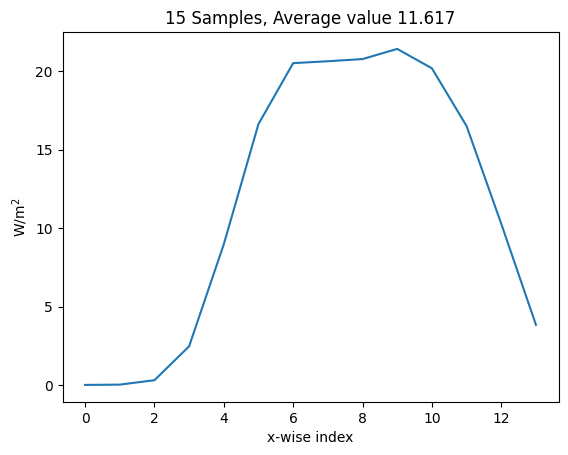

In [ ]:
plt.plot(list(results))
plt.ylabel("W/m$^2$")
plt.xlabel("x-wise index")
plt.title(f"{len(xs)+1} Samples, Average value {np.mean(results):.3f}")
plt.show()